# Aula 17 - Gradient Boosting

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from lightgbm import LGBMClassifier, plot_metric, plot_tree, create_tree_digraph
from scipy.stats import randint, uniform 
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.inspection import plot_partial_dependence
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

/Users/paulo.castro/miniconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
shap.initjs()

## Introduction to Boosting

_Mistakes are made for learning not repeating_

Métodos de _ensemble_ foram projetados para extraír performance a partir da combinação de diversos classificadores (ou regressores). Diferente da técnica de _stacking_ que pode combinar algoritmos diferentes, geralmente usamos ensembles para combinar classificadores que são treinados com o mesmo algoritmo. Nas aulas anteriores, foi explorada a técnica de _bagging_ que é um dos pilares do algoritmo de Random Forests. Essa técnica consiste em sortear porções aleatórias do seu conjunto de treino e com ele fitar um modelo usando um algoritmo como Decision Trees. Esses modelos são então combinados via uma votação (no caso de um modelo de classificação).

Boosting é um técnica criada no início dos anos 90 para respoder a pergunta "É possível criar um modelo forte a partir de um conjunto de modelos fracos?". Modelos fracos, nesse caso, são aqueles que são apenas ligeiramente melhores do que um chute aleatório, e forte é um modelo com a performance arbitrariamente alta. De lá pra cá, Boosting foi aplicado com sucesso em diversas indústrias, sendo até hoje um dos algoritmos mais utilizados para fazer previsões usando dados estruturados (leia-se dados tabulares com número e categorias como features).

A técnica de boosting consiste em iterativamente fitar modelos fracos e, quando combinados, formar um modelo forte. A estratégia por trás destas iterações distinguem os diferentes algoritmos.

![bagging_boosting](img/bagging_boosting.png)

### AdaBoost

Este algoritmos consiste, usualmente, em diversas árvores de decisão fracas (geralmente de apenas um split). Depois de ajustar o primeiro modelo, você dá pesos diferentes para aqueles exemplos que o modelo errou. Usando esses pesos, você treina a próxima árvore. A ideia aqui é que você consiga dar mais peso para os erros que você está cometendo e com isso aprender o que os modelos anteriores deixaram de aprender.

![adaboost](img/adaboost.png)

Não iremos cobrir AdaBoost pois usualmente ele não oferece resultados melhores do que o próximo algoritimo. Mesmo assim, caso estejam curiosos sobre como esses pesos são setados, aqui está uma descrição do algoritmo:

https://miro.medium.com/max/1390/0*oxAkJZ1WEe_-ugoe.png

### Gradient Boosting

Esta é a técnica mais popular de Boosting em uso hoje em dia. A ideia aqui é que, a cada iteração, um modelo é ajustado para prever os erros residuais do modelo até agora. Uma maneira simples de introduzir o assunto é usando um modelo cuja _loss function_ é o erro quadrático médio.

A cada passo $m$ o algoritmo vai melhorar o resultado do modelo $F_{m-1}(x)$ somando um modelo fraco $h(x)$ tal que:

$F_m(x) = F_{m-1} + h(x)$

No entando, a ideia é que $F_m(x)$ seja igual a $y$ que é o valor que você está estimando:

$F_m(x) = F_{m-1} + h(x) \approx y$

Fazendo as contas, é possível ver que:

$h(x) \approx y - F_{m-1}(x)$

Ou seja, esse modelo fraco não vai tentar prever $y$ mas sim a diferença que sobrou entre $y$ e o modelo atual. Claro que isso só vale para quando a loss é data por $\mathcal{L} = \frac{1}{2}(y - F(x))^2$, mas a generalização é simples, basta observar que $y - F_{m-1}(x)$ é o negativo do gradiente da loss, ou seja:

$h(x) = - \frac{\partial \mathcal{L}}{\partial F(X)} = - \nabla_{F_m(X)} \mathcal{L}$

Inclusive, de maneira muito interessante, o passo de atualização é escrito como:

$F_m(x) = F_{m-1} - \gamma_m \nabla_{F_m(X)} \mathcal{L}$

Que é o algoritmo de descida de gradiente. Por isso o nome _Gradient Boosting_! Olha só como isso fica na prática:

![gradient_desc](img/gradient_descent.png)

## Hands-on!

Nesse exercício usaremos o dataset de doenças caríacas da UCI chamado [Heart Disease UCI Dataset](https://www.kaggle.com/ronitf/heart-disease-uci). Esse dataset contém informações de diversos pacientes, inclusive uma variável booleana dizendo se o paciente tinha (ou não) doenças cardíacas. Esse dataset foi usado em diversos estudos e conta também com muita participação da comunidade Kaggle na forma de [kernels](https://www.kaggle.com/ronitf/heart-disease-uci/kernels) que você pode conferir e usar como inspiração.

In [3]:
df = pd.read_csv('data/heart.csv')

In [4]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

- **age** age in years
- **sex** (1 = male; 0 = female)
- **cp** chest pain type (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps** resting blood pressure (in mm Hg on admission to the hospital)
- **chol** serum cholestoral in mg/dl
- **fbs** fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- **restecg** resting electrocardiographic results
- **thalach** maximum heart rate achieved
- **exang** exercise induced angina (1 = yes; 0 = no)
- **oldpeakST** depression induced by exercise relative to rest
- **slope** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca** number of major vessels (0-3) colored by flourosopy
- **thal** 3 = normal; 6 = fixed defect; 7 = reversable defect
- **target** 1 = has disease; 0 = no disease

In [5]:
X = df.drop(columns=['target'])
y = df['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

<div class="alert alert-block alert-info">
<b>Exercício (7 min):</b>

Carregue o dataset de churn e faça uma pequena exploração dos dados. Converta os dados categóricos para o tipo `category` usando o método `.astype("category")`. Mude seu target para ser binário (1 ou 0) ao invés de "Yes" e "No". Converta também a coluna "TotalCharges" para o tipo `float64`.
    
Depois disso, separe seus dados em um conjunto de treino e outro de teste.
    
Do que se trata esse dataset? Qual sua origem? Quais são as features? Existem features categóricas? Features com valores nulos? O target é balanceado? O que mais você pode dizer sobre ele?
    
Link para o dataset: https://www.kaggle.com/blastchar/telco-customer-churn
</div>

In [7]:
df2 = pd.read_csv('data/churn.csv')
X2 = df2.drop(columns=['Churn', 'customerID'])
y2 = df2['Churn']

## Training a model

In [21]:
model = LGBMClassifier(n_estimators=100, random_state=0)

In [22]:
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [23]:
y_pred_proba

array([5.70862703e-02, 9.92810144e-01, 4.12423027e-01, 8.32112855e-04,
       6.36784397e-02, 6.49686449e-01, 4.85148045e-02, 3.52679755e-02,
       2.72374769e-04, 2.46016944e-03, 9.41897889e-01, 9.85454766e-01,
       3.76215735e-02, 9.87948740e-01, 9.95446114e-01, 7.41461971e-01,
       7.47254149e-02, 8.89899624e-01, 1.09055095e-02, 7.38504215e-01,
       9.04660947e-01, 1.23488241e-01, 3.86204103e-02, 9.60967417e-02,
       7.20506664e-01, 7.71726958e-01, 7.51104269e-02, 3.19397754e-01,
       9.89915338e-01, 9.14137065e-01, 8.16647788e-01, 1.17092239e-02,
       9.95793173e-01, 9.88719861e-01, 9.90998824e-01, 3.30032957e-01,
       2.12275912e-02, 9.42597258e-01, 2.27796096e-02, 7.94931346e-03,
       9.23018960e-01, 1.74943740e-01, 9.61040852e-01, 4.71956240e-02,
       3.12014378e-01, 8.36682990e-01, 9.74887825e-01, 7.63616881e-01,
       8.56029283e-04, 8.46165747e-01, 9.72533868e-01, 9.79802741e-01,
       9.98051329e-01, 8.70415036e-01, 9.99500849e-01, 4.02455134e-02,
      

### Evaluating your model 

In [24]:
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_title('Receiver Operating Characteristic')
    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    return ax

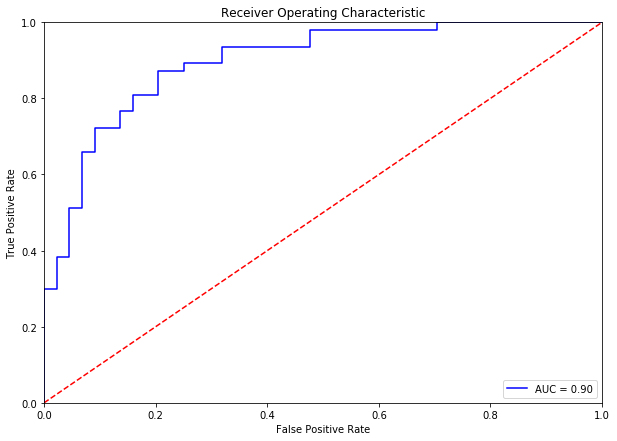

In [25]:
plot_roc_curve(y_test, y_pred_proba)

In [26]:
roc_auc_score(y_test, y_pred_proba)

0.8965183752417795

### Choosing a threshold

In [27]:
def plot_precision_recall(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(thresholds, precisions[:-1], "r--", label="Precisions")
    ax.plot(thresholds, recalls[:-1], "#424242", label="Recalls")
    ax.set_title("Precision and Recall \n Tradeoff", fontsize=18)
    ax.set_ylabel("Level of Precision and Recall", fontsize=16)
    ax.set_xlabel("Thresholds", fontsize=16)
    ax.legend(loc="best", fontsize=14)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    return ax

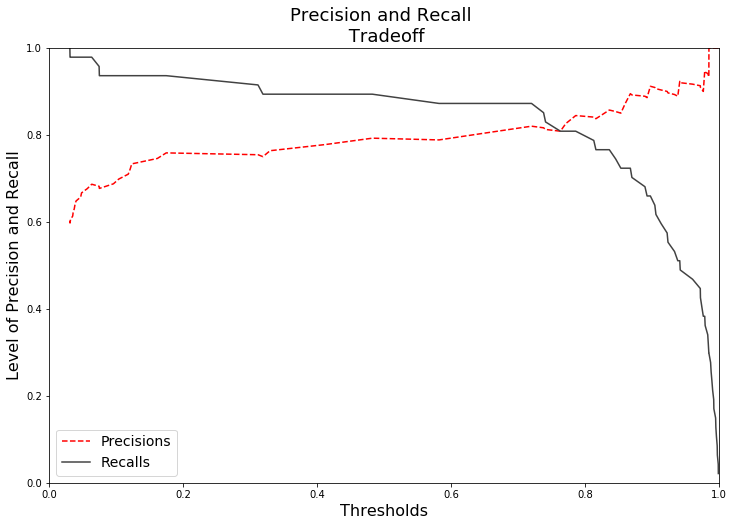

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plot_precision_recall(precisions, recalls, thresholds)

In [29]:
threshold = 0.3
y_pred = y_pred_proba > threshold

In [30]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df = pd.DataFrame(cm.T, index=["has disease", "no disease"], columns=["has disease", "no disease"])
    ax = sns.heatmap(df, annot=True)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    return ax

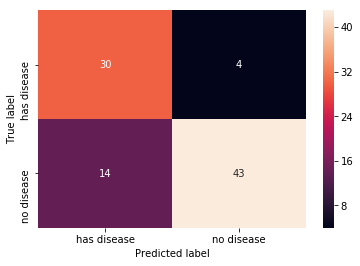

In [31]:
plot_confusion_matrix(y_test, y_pred)

<div class="alert alert-block alert-info">
<b>Exercício (15 min):</b>

Use os dados que você carregou acima para criar e avaliar um modelo que tenta prever Churn. Para isso compare 3 modelos: regressão logística, decision tree e gradient boosting. Note que você vai precisar mudar os tipos das colunas! Para as colunas categóricas, tente usar o Qual deles é melhor? Para que pode ser usado esse modelo? O que é mais importante nesse caso, precision ou recall?
</div>

## Optimizing hyperparameters

In [40]:
param_test ={
    'num_leaves': randint(3, 10), 
    'min_child_samples': randint(50, 150),
    'learning_rate': uniform(0.01, 0.1)
}

In [41]:
clf = LGBMClassifier(random_state=0, silent=True)
model = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_test, 
    n_iter=100,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=0,
    verbose=True
)

In [42]:
model.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(model.best_score_, model.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score reached: 0.8874083134353979 with params: {'learning_rate': 0.06684339488686485, 'min_child_samples': 50, 'num_leaves': 7} 


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    5.1s finished
/Users/paulo.castro/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [43]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

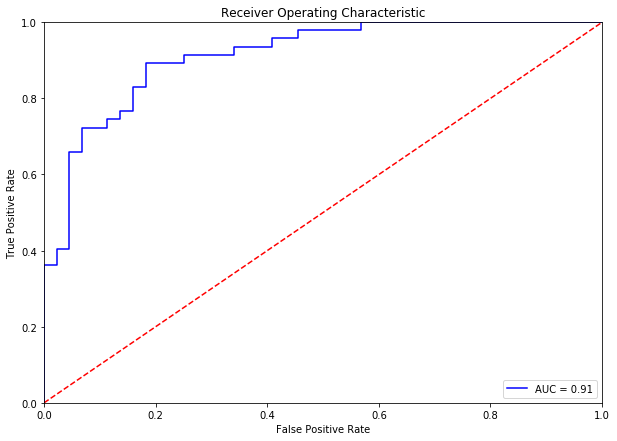

In [44]:
plot_roc_curve(y_test, y_pred_proba)

<div class="alert alert-block alert-info">
<b>Exercício (12 min):</b>

Otimize os parametros do seu modelo de Churn. Tente usar os parâmetros `num_leaves`, `min_child_samples`, `learning_rate`. Experimente também com outros parametros. Use o guia se quiser:

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
    
Se tiver dúvida sobre quais valores você deve testar para cada parâmetros, tente descobrir o valor usado por padrão e explore valores próximos. Você conseguiu alguma melhoria de performance com essa otimização? 
</div>

## Understanding your model

In [50]:
model = LGBMClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

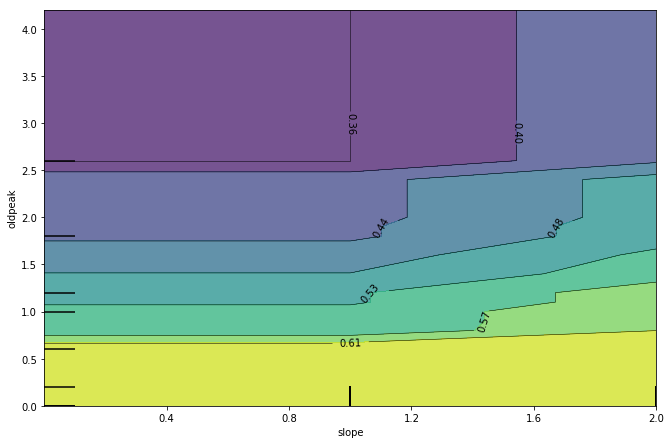

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
plot_partial_dependence(model, X_test, features=[(10, 9)], feature_names=X_test.columns.values.tolist(), fig=fig)

In [52]:
explainer = shap.TreeExplainer(model, X_train, model_output='probability', feature_dependence='independent')
shap_values = explainer.shap_values(X_test)

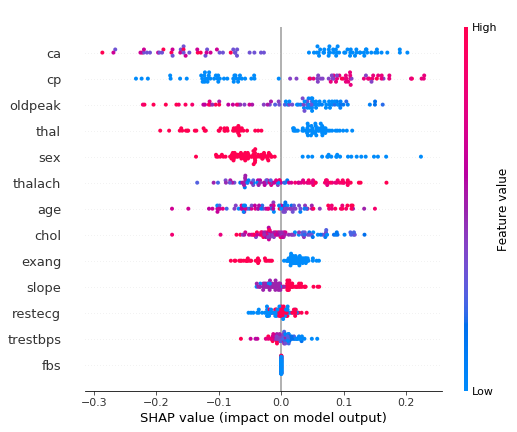

In [53]:
shap.summary_plot(shap_values, X_test)

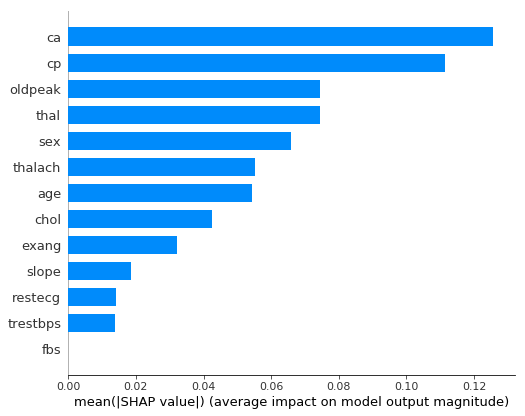

In [54]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Why are we saying someone has (or hasn't) a heart disease? 

In [55]:
def force_plot(explainer, patient):
    shap_values = explainer.shap_values(patient)
    return shap.force_plot(explainer.expected_value, shap_values, patient)

In [56]:
force_plot(explainer, patient=X_test.iloc[[0], :])

<div class="alert alert-block alert-info">
<b>Exercício (12 min):</b>

Qual é a importância de cada feature no seu modelo de churn? Quais features parecem impactar mais seu modelo? Quais delas parecem ser pouco preditivas?
    
    
Escolha um candidato ao acaso e suponha que um stakeholder pergunte "por que decidimos que essa pessoa vai fazer churn?", responda essa pergunta se baseando em dados e explique quais foram as características dos clientes que mais impactaram a decisão.
</div>

<div class="alert alert-block alert-warning">
<b>Dica</b>

* O SHAP só aceita features numéricas, use o OneHotEncoder para transformar as colunas categóricas em números.
* Ao invés de usar o transformer "passthrough" use a classe PassthroughTransformer mostrada abaixo
</div>

In [57]:
from sklearn.base import TransformerMixin, BaseEstimator

# Changed the base classes here, see Point 3
class PassthroughTransformer(BaseEstimator, TransformerMixin):

    # I corrected the `fit()` method here, it should take X, y as input
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = X
        return X

    # I have corrected the output here, See point 2
    def get_feature_names(self):
        return self.X.columns.tolist()

## Feature selection

In [64]:
clf = LGBMClassifier(n_estimators=100, random_state=0)
selector = RFECV(clf, min_features_to_select=5, cv=5, scoring='roc_auc')
selector.fit(X_train, y_train)

RFECV(cv=5,
      estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0, importance_type='split',
                               learning_rate=0.1, max_depth=-1,
                               min_child_samples=20, min_child_weight=0.001,
                               min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                               num_leaves=31, objective=None, random_state=0,
                               reg_alpha=0.0, reg_lambda=0.0, silent=True,
                               subsample=1.0, subsample_for_bin=200000,
                               subsample_freq=0),
      min_features_to_select=5, n_jobs=None, scoring='roc_auc', step=1,
      verbose=0)

In [65]:
X_train_select = selector.transform(X_train)

In [66]:
X_train.iloc[selector.support_, :]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
137,62,1,1,128,208,1,0,140,0,0.0,2,0,2
106,69,1,3,160,234,1,0,131,0,0.1,1,1,2
284,61,1,0,140,207,0,0,138,1,1.9,2,1,3
44,39,1,2,140,321,0,0,182,0,0.0,2,0,2
139,64,1,0,128,263,0,1,105,1,0.2,1,1,3
288,57,1,0,110,335,0,1,143,1,3.0,1,1,3
156,47,1,2,130,253,0,1,179,0,0.0,2,0,2
252,62,0,0,138,294,1,1,106,0,1.9,1,3,2
234,70,1,0,130,322,0,0,109,0,2.4,1,3,2
18,43,1,0,150,247,0,1,171,0,1.5,2,0,2


In [77]:
clf1 = LGBMClassifier(n_estimators=100, random_state=0)
selector = RFECV(clf1, min_features_to_select=5, cv=5, scoring='roc_auc')

param_test ={
    'num_leaves': randint(3, 10), 
    'min_child_samples': randint(50, 150),
    'learning_rate': uniform(0.01, 0.1)
}

clf2 = LGBMClassifier(random_state=0, silent=True)
model = RandomizedSearchCV(
    estimator=clf2,
    param_distributions=param_test, 
    n_iter=100,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=0,
    verbose=True
)

pipeline = make_pipeline(selector, model)

In [78]:
pipeline.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.8s finished
/Users/paulo.castro/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Pipeline(memory=None,
         steps=[('rfecv',
                 RFECV(cv=5,
                       estimator=LGBMClassifier(boosting_type='gbdt',
                                                class_weight=None,
                                                colsample_bytree=1.0,
                                                importance_type='split',
                                                learning_rate=0.1, max_depth=-1,
                                                min_child_samples=20,
                                                min_child_weight=0.001,
                                                min_split_gain=0.0,
                                                n_estimators=100, n_jobs=-1,
                                                num_leaves=31, objective=None,
                                                random_state=0, reg_alpha=0.0,
                                                reg_lambda=0.0...
                                    param_distribut

In [79]:
y_pred_proba_select = pipeline.predict_proba(X_test)[:, 1]

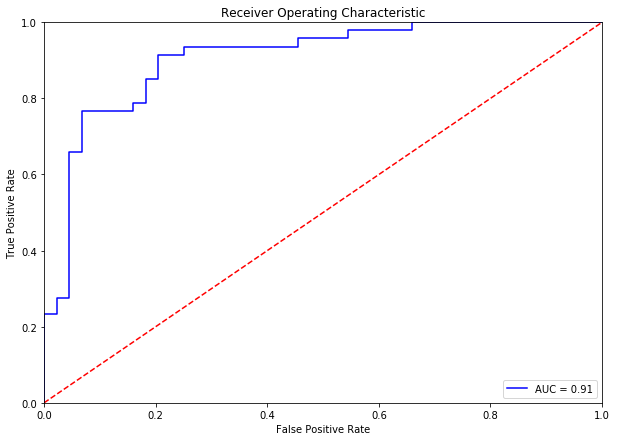

In [80]:
plot_roc_curve(y_test, y_pred_proba_select)

<div class="alert alert-block alert-info">
<b>Exercício (10 min):</b>
    
Selecione as features para o seu modelo, mas desta vez, use o método `SelectFromModel` (já importado para você) e passe para ele o estimador `LassoCV` (esse modelo é uma regressão logística com regularização). Quais features foram selecionada? Quais foram deixadas de fora?
    
Agora, treine o modelo com o pipeline completo (seleção das features + treinar o boosting). Qual foi a performance do novo modelo? Por que?
</div>

<div class="alert alert-block alert-warning">
<b>Dica</b>

* O LassoCV só aceita features numéricas, use o OneHotEncoder para transformar as colunas categóricas em números.
* Ao invés de usar o transformer "passthrough" use a classe PassthroughTransformer mostrada acima
</div>